# A Predictive Study on PM 2.5 Level in Beijing, China # 
**Authors**: Edward Wang, Jinghan Xu, Minzhang Si, Sammy Gulipalli

In [1]:
### Load Necessary Packages & Libraries
library(broom)
#install.packages("leaps")
library(latex2exp)
library(tidyverse)
library(repr)
library(digest)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(GGally)
## For multiple imputation
# install.packages("mice")
library(mice)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-6

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is maske

## 1. Introduction
Air pollution is a major global issue, affecting both developed and developing countries. It has been linked to numerous negative health outcomes, including respiratory and cardiovascular diseases, cancer, and premature death (World Health Organization, 2018). In particular, fine particulate matter known as PM2.5 has been identified as a major contributor to the negative health impacts of air pollution. As such, understanding the factors that influence PM2.5 concentrations and developing effective strategies for mitigating these concentrations is of great importance.

In this project, we will analyze two datasets on air quality in Beijing, China in order to better understand the drivers of PM2.5 concentrations in the city. The first dataset, available from the UCI Machine Learning Repository, includes data on PM2.5 concentrations and various meteorological variables from 2010 to 2014 (UCI Machine Learning Repository, n.d.). The second dataset, also from the UCI Machine Learning Repository, contains data on PM2.5 as well as four additional air pollutants - PM10, SO2, O3, and NO2 - from 2013 to 2017, with data broken down by individual monitoring stations within the city (UCI Machine Learning Repository, n.d.). By merging these datasets, we can examine the relationship between PM2.5 and other pollutants over a longer time period and at a more detailed spatial scale.

In order to develop a linear regression model for predicting PM2.5 concentrations in Beijing, we will use data from 2013 and 2014 for training and testing. This approach allows us to evaluate the model's performance on a portion of the data while still utilizing the expanded set of variables provided by the second dataset. The model will be developed using various statistical and machine learning techniques discussed in the course, such as foward selection, LASSO, and Ridge regularization.

Understanding the factors that influence PM2.5 concentrations in Beijing is of great importance for policy makers and other stakeholders working to improve air quality in the city. The results of this project will provide insights into the key drivers of PM2.5 concentrations in Beijing, and the developed model will be a valuable tool for predicting future PM2.5 concentrations. This information can be used to inform the development of policies and interventions aimed at reducing PM2.5 levels and improving air quality in the city.

## 2. Dataset Selection, Analysis, & Reasoning  
In the light of some useful suggestions given by the peer reviews, our group decides to add in a new set of variables to represent hourly air quality in Beijing, China. To do this, we will attach another dataset (Beijing Multi-Site Air-Quality Data) to our existing one & use their time intersections (2013 - 2014) as our final, expanded set to train & test our predictive model.
### 2.1 Dataset Loading & Combining:
Primarily, we want to use variables such that hourly PM10 concentration in the air to represent the hourly air quality in the city; However, given that the second dataset contains 12 separate files each representing hourly data from a sepcific monitoring station, we decide to take the average of these values & combine these variables with our existing dataset. This leaves us with 16 variables in total:

- Response variable:
1. `pm2.5`: PM2.5 concentration (ug/m^3); (numeric, continuous)

- Input Variables representing **Time**
1. `year`: year of data in this row; (numeric, discrete)
2. `month`: month of data in this row; (numeric, discrete)
3. `day`: day of data in this row; (numeric, discrete)
4. `hour`: hour of data in this row; (numeric, discrete)

- Input Variables representing **Weather Conditions**:
1. `DEWP`: Dew Point (â„ƒ); (numeric, continuous)
2. `TEMP`: Temperature (â„ƒ); (numeric, continuous)
3. `PRES`: Pressure (hPa); (numeric, continuous)
4. `Iws`: Cumulated wind speed (m/s); (numeric, continuous)
5. `Is`: Cumulated hours of snow; (numeric, continuous)
6. `Ir`: Cumulated hours of rain; (numeric, continuous)

- Input Variables representing **Air Quality**:
1. `PM10`: PM10 concentration (ug/m^3); (numeric, continuous)
2. `SO2`: SO2 concentration (ug/m^3); (numeric, continuous)
3. `NO2`: NO2 concentration (ug/m^3); (numeric, continuous)
4. `CO`: CO concentration (ug/m^3); (numeric, continuous)
5. `O3`: O3 concentration (ug/m^3); (numeric, continuous)

In [2]:
## Load datasets:
PM2.5_data_2010_2014 <- read.csv(file = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip"
download.file(url, "data.zip")
unzip("data.zip")
list_csv_files_names <- list.files(path = "./PRSA_Data_20130301-20170228/") ## to get all the csv file names
### Get the working relative path for each file by district
for (i in 1:length(list_csv_files_names)) {list_csv_files_names[i] = paste('./PRSA_Data_20130301-20170228/', list_csv_files_names[i], sep="")}
PM2.5_data_2013_2017_by_station <- read_csv(list_csv_files_names, id = "file_name")
### Since we only need the data by the entire city, not by 12 seperate stations, we will take the mean value of all stations as our data
### for a specific hour.
PM2.5_data_2013_2017 <- PM2.5_data_2013_2017_by_station %>%
                        select(- station) %>%
                        group_by(year,month,day,hour) %>%
                        summarize(PM2.5 = mean(PM2.5),
                                  PM10 = mean(PM10),
                                  SO2 = mean(SO2),
                                 NO2 = mean(NO2),
                                 O3 = mean(O3),
                                 CO = mean(CO))
## Combine PM10, SO2, NO2, O3 columns from 2013 - 2014 to the other dataset
PM2.5_data_2013_2014_1 <- PM2.5_data_2010_2014 %>%
                          filter(year == 2013 | year == 2014)
PM2.5_data_2013_2014_2 <- PM2.5_data_2013_2017 %>%
                          filter(year == 2013 | year == 2014) %>%
                          select(year,month,day,hour, PM10, SO2, O3,NO2,CO)
PM2.5_data_2013_2014_full <- merge(PM2.5_data_2013_2014_1, PM2.5_data_2013_2014_2, all = TRUE) %>%
                             select(- No, -cbwd)
head(PM2.5_data_2013_2014_full)

Rows: 420768 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): wd, station
dbl (16): No, year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'year', 'month', 'day'. You can override
using the `.groups` argument.


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,PM10,SO2,O3,NO2,CO
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013,1,1,0,35,-10,-5,1018,5.81,0,0,NA,NA,NA,NA,NA
2,2013,1,1,1,31,-11,-7,1017,9.83,0,0,NA,NA,NA,NA,NA
3,2013,1,1,2,32,-11,-7,1017,11.62,0,0,NA,NA,NA,NA,NA
4,2013,1,1,3,21,-14,-10,1018,14.75,0,0,NA,NA,NA,NA,NA
5,2013,1,1,4,16,-15,-10,1018,0.45,0,0,NA,NA,NA,NA,NA
6,2013,1,1,5,15,-15,-12,1019,3.13,0,0,NA,NA,NA,NA,NA


### 2.1 Handling the Missing Data

In [3]:
missing_rate <- 1 - (nrow(PM2.5_data_2013_2014_full %>% drop_na()) / nrow(PM2.5_data_2013_2014_full))
missing_rate

[1] 0.6636416

After combining the rows, we have noticed that about 66.3% of the rows in the datasets are missing at least one value. Knowing that discarding all the rows with missing data may lead to poorer performance (due to a only using a much smaller dataset) of the final model, we choose to use the imputation medthod from `MICE` package to address this issue. 

In [4]:
imputed_data <- mice(PM2.5_data_2013_2014_full, m = 1)
PM2.5_data_2013_2014_full <- complete(imputed_data) ##Choose the first imputed dataset as our dataset
mising_rate_table <- tibble(data = c("original dataset", "new dataset"), missing_rate = c(missing_rate,1 - (nrow(PM2.5_data_2013_2014_full %>% drop_na()) / nrow(PM2.5_data_2013_2014_full))))
head(PM2.5_data_2013_2014_full)
mising_rate_table


 iter imp variable
  1   1  pm2.5  PM10  SO2  O3  NO2  CO
  2   1  pm2.5  PM10  SO2  O3  NO2  CO
  3   1  pm2.5  PM10  SO2  O3  NO2  CO
  4   1  pm2.5  PM10  SO2  O3  NO2  CO
  5   1  pm2.5  PM10  SO2  O3  NO2  CO


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,PM10,SO2,O3,NO2,CO
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013,1,1,0,35,-10,-5,1018,5.81,0,0,32.500000,17.91667,5.833333,46.58333,841.6667
2,2013,1,1,1,31,-11,-7,1017,9.83,0,0,18.916667,32.17760,2.416667,43.00000,783.3333
3,2013,1,1,2,32,-11,-7,1017,11.62,0,0,12.583333,37.85533,3.416667,61.01830,950.0000
4,2013,1,1,3,21,-14,-10,1018,14.75,0,0,22.416667,16.58333,27.166667,41.00000,975.0000
5,2013,1,1,4,16,-15,-10,1018,0.45,0,0,49.833333,41.25000,3.416667,64.50000,1075.0000
6,2013,1,1,5,15,-15,-12,1019,3.13,0,0,6.083333,76.41667,56.833333,45.91667,1625.0000


data,missing_rate
<chr>,<dbl>
original dataset,0.6636416
new dataset,0.0000000


With the imputation method filling up the missing data, we can see that with the current mising rate is 0 meaning there is no rows with missing data in our new dataset. 

### 2.3 Data Splitting:
We will split our data randomly into training (80%) & testing set (20%) so that we can evaluate our model in the end with unseen data. 

In [5]:
### Split for training & test set:
set.seed(2022)
PM2.5_train <- PM2.5_data_2013_2014_full %>% 
               slice_sample(prop = 0.8)
PM2.5_test <- PM2.5_data_2013_2014_full %>% 
              anti_join(PM2.5_train)
head(PM2.5_train)
head(PM2.5_test)

Joining, by = c("year", "month", "day", "hour", "pm2.5", "DEWP", "TEMP",
"PRES", "Iws", "Is", "Ir", "PM10", "SO2", "O3", "NO2", "CO")


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,PM10,SO2,O3,NO2,CO
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2014,2,7,2,101,-7,-2,1030,15.65,0,0,120.25000,61.128933,2.083333,88.000000,1525.0000
2,2013,11,25,13,13,-17,7,1018,137.69,0,0,17.16667,7.750000,57.115033,9.860392,391.6667
3,2013,4,30,14,12,-9,28,1012,3.13,0,0,34.08333,5.500000,112.916667,35.701517,300.0000
4,2014,5,20,10,17,8,26,1006,28.62,0,0,42.66667,5.416667,85.833333,14.416667,416.6667
5,2014,1,6,19,167,-6,-2,1024,0.89,0,0,169.25000,44.916667,13.333333,79.500000,2141.6667
6,2013,7,22,21,124,19,26,1003,0.89,0,0,128.58333,17.045467,120.216517,46.234108,1012.5000


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,PM10,SO2,O3,NO2,CO
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013,1,1,7,9,-16,-6,1020,4.92,0,0,34.583333,53.25000,11.583333,51.16667,1958.3333
2,2013,1,1,10,11,-22,-3,1023,21.01,0,0,12.250000,6.50000,19.750000,23.75886,450.0000
3,2013,1,1,15,15,-25,-5,1025,63.04,0,0,19.166667,33.41667,34.500000,15.65179,408.3333
4,2013,1,1,20,17,-26,-10,1030,103.28,0,0,29.666667,43.41667,17.750000,53.25000,1058.3333
5,2013,1,1,22,19,-27,-11,1032,118.48,0,0,9.833333,26.83333,7.166667,53.50000,616.6667
6,2013,1,2,2,19,-28,-12,1034,148.88,0,0,7.333333,40.33333,2.166667,35.91667,850.0000


### 2.4 Training Set Visualisation & Analysis:
The following code will try to visualize the correlation between different input variables and the response variable. To do that, we decide to use both a heat map of correlations between variables & a ggpair plot to check both the correlation & trends among all variables.  

#### 2.4.1 Paried Plot:
Since our current dataset is too huge to run `ggpairs` (running them on the whole set will kill the kernel), we instead will use a random sample from the data to give an unbiased estimate of the correlations & the relationship between the weather condition & air quality variables

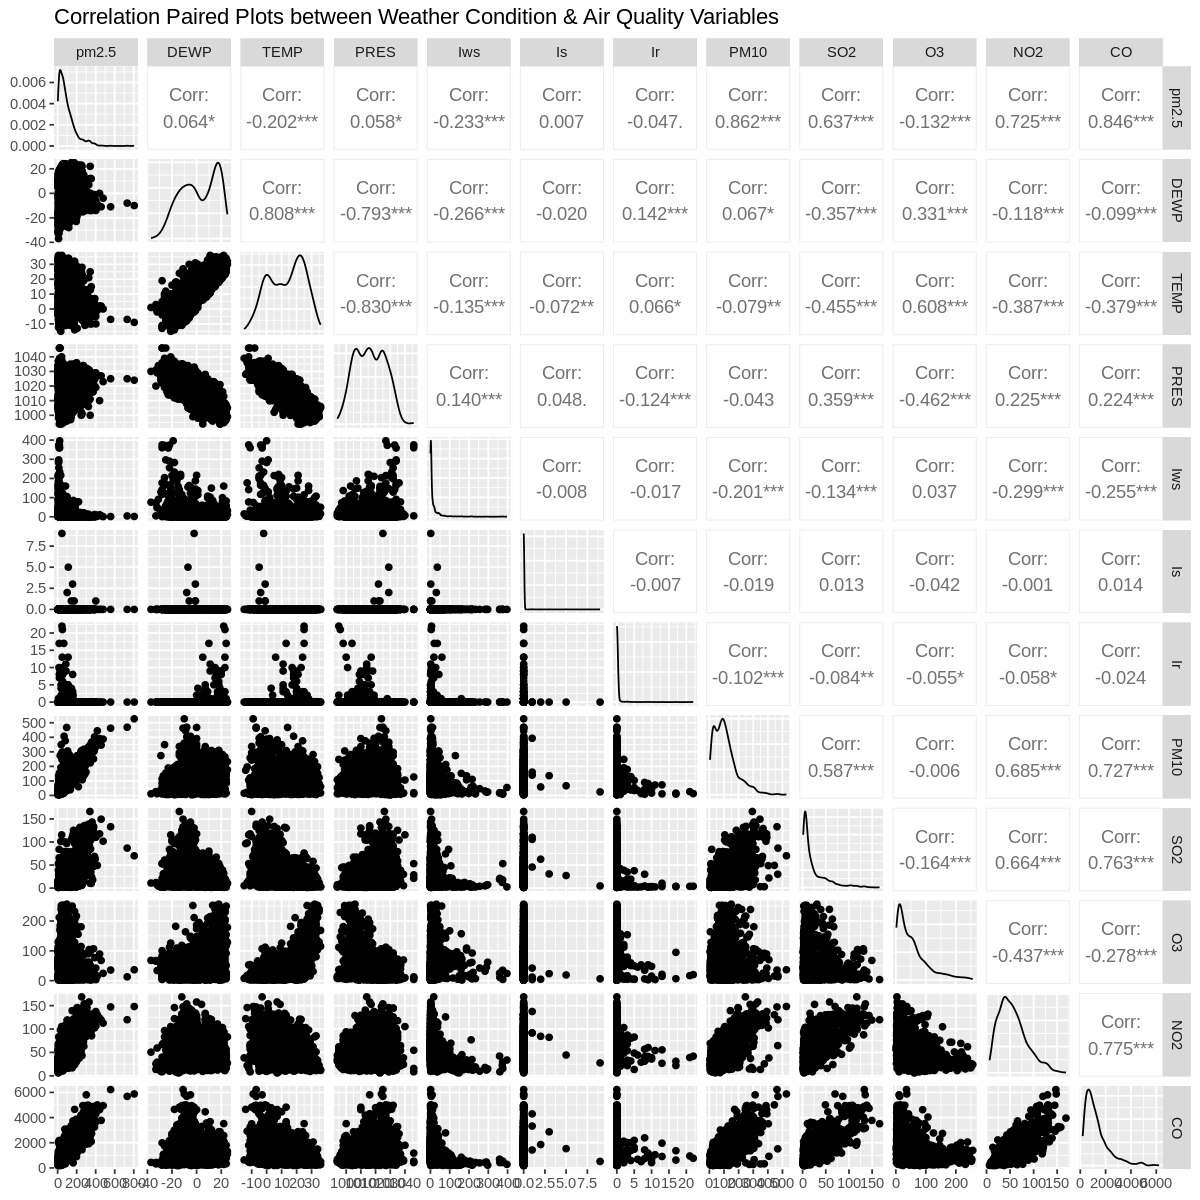

In [6]:
## take a 10% sample to visualize the relationship between weather condition variables & air quality variables
PM2.5_train_visualization_sample  <- PM2.5_train %>% slice_sample(prop = 0.1)
pair_plot <- ggpairs(PM2.5_train_visualization_sample[,-c(1:4)], title = "Correlation Paired Plots between Weather Condition & Air Quality Variables")
options(repr.plot.width=10, repr.plot.height=10)
pair_plot

#### 2.4.2 Heat Map of Correlations
The following code produces a heatmap between all variables with the corresponding correlation values attached.

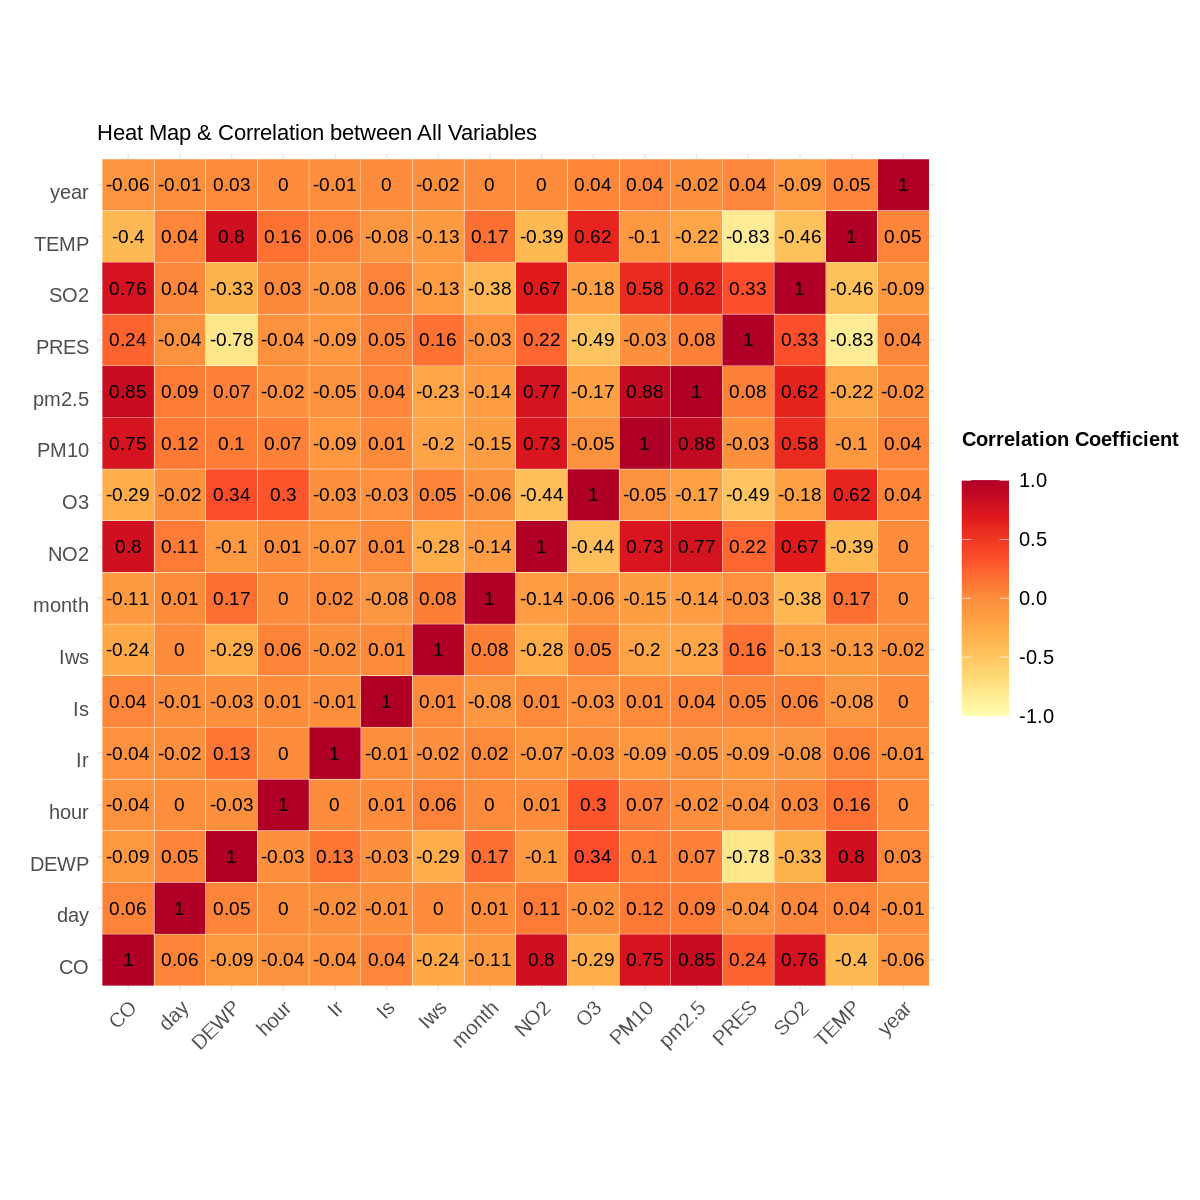

In [7]:
## Heatmap
## Calculate the coefficient matrix
corr_matrix <- PM2.5_train %>%
               cor() %>%
               as.data.frame() %>%
               rownames_to_column("var1") %>%
               pivot_longer(-var1, names_to = "var2", values_to = "corr")
### Visualize Heatmap
plot_corr_matrix <- corr_matrix %>%
   ggplot(aes(x = var1, y = var2)) +
   geom_tile(aes(fill = corr), color = "white") + 
   scale_fill_distiller("Correlation Coefficient \n",
     palette =  "YlOrRd",
     direction = 1, limits = c(-1, 1)
   ) +
   labs(x = "", y = "") +
   theme_minimal() +
   theme(
     axis.text.x = element_text(
       angle = 45, vjust = 1,
       size = 12, hjust = 1
     ),
     axis.text.y = element_text(
       vjust = 1,
       size = 12, hjust = 1
     ),
     legend.title = element_text(size = 12, face = "bold"),
     legend.text = element_text(size = 12),
     legend.key.size = unit(1, "cm")
   ) +
   coord_fixed() +
    geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 4) +
    ggtitle("Heat Map & Correlation between All Variables")
options(repr.plot.width=10, repr.plot.height=10)
plot_corr_matrix

From the above visualizations of the training data, we observe that on average the air quality (in particular `SO2`, `NO2`, `PM10`, & `CO`) variables are more correlated with the response variable `pm2.5`. This information can be helpful in pre-determining our model created by forward selection or LASSO before the cross validation since we expect a good model to contain the most correlated variables (in this case, air quality variables). 

## 3. Model Training & Selection
With the training set already obtained, we will proceed to train four linear models (LASSO, Ridge, Full OLS, Forward Selection) & evaluate their performance using the RMSE (root mean squared error) obtained from a validation set (10% of the training data) taken from the training data.  

In [8]:
### Validation Set:
set.seed(10)
PM2.5_train_final <- PM2.5_train %>% 
                     slice_sample(prop = 0.9)
PM2.5_validation <- PM2.5_train %>% 
                    anti_join(PM2.5_train_final)

Joining, by = c("year", "month", "day", "hour", "pm2.5", "DEWP", "TEMP",
"PRES", "Iws", "Is", "Ir", "PM10", "SO2", "O3", "NO2", "CO")


### 3.1 Full OLS Regression
The following code will train a full linear regression model using all the input variables & will compute RMSE of the validation set for the model fitted. 

In [9]:
# full ols prediction
PM2.5_full_OLS <- lm(pm2.5 ~., data = PM2.5_train_final)
tidy(PM2.5_full_OLS)
PM2.5_test_pred_full_OLS <- predict(PM2.5_full_OLS, newdata = PM2.5_validation)
# compute rmse for full model
PM2.5_R_MSE_models <- tibble(
  Model = "OLS Full Regression",
  R_MSE = rmse(
    preds = PM2.5_test_pred_full_OLS,
    actuals = PM2.5_validation$pm2.5
  )
)
PM2.5_R_MSE_models

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.070648e+04,1.247178e+03,8.5845601,1.018132e-17
year,-5.642986e+00,6.240812e-01,-9.0420700,1.760048e-19
month,-1.208013e+00,1.037063e-01,-11.6484000,3.378422e-31
day,-5.155301e-03,3.484730e-02,-0.1479397,8.823927e-01
hour,-3.575008e-01,4.910388e-02,-7.2804993,3.523350e-13
DEWP,1.164016e+00,4.742244e-02,24.5456898,5.299837e-130
TEMP,-7.514993e-01,7.163332e-02,-10.4909181,1.212971e-25
PRES,6.351095e-01,5.985849e-02,10.6101826,3.446511e-26
Iws,4.477389e-02,7.632742e-03,5.8660300,4.575620e-09


Model,R_MSE
<chr>,<dbl>
OLS Full Regression,34.25041


### 3.2 Forward Selection Method
To build a model by forward selection, we will first select variables using the forward selection algorithm & choose the best model based on the smallest $C_p$ (an estimator of the test error) & then fit another linear model using the variables chosen. In the end, we will evaluate the fitted model using the RMSE from the validation set. 

In [10]:
# forward selection
PM2.5_forward_sel <- regsubsets(
    x = pm2.5 ~., nvmax = 15, #Given that there are in total 14 possible input variables
    data = PM2.5_train_final,
    method = "forward")
PM2.5_forward_summary<-summary(PM2.5_forward_sel)
## To create a table of various statistics given by the forward selection algorithm
PM2.5_forward_summary_df<- tibble(
    n_input_variables = 1:15,
    RSQ = PM2.5_forward_summary$rsq,
    RSS = PM2.5_forward_summary$rss,
    ADJ.R2 = PM2.5_forward_summary$adjr2,
    Cp = PM2.5_forward_summary$cp,
    BIC = PM2.5_forward_summary$bic,)
PM2.5_forward_summary
PM2.5_forward_summary_df

Subset selection object
Call: regsubsets.formula(x = pm2.5 ~ ., nvmax = 15, data = PM2.5_train_final, 
    method = "forward")
15 Variables  (and intercept)
      Forced in Forced out
year      FALSE      FALSE
month     FALSE      FALSE
day       FALSE      FALSE
hour      FALSE      FALSE
DEWP      FALSE      FALSE
TEMP      FALSE      FALSE
PRES      FALSE      FALSE
Iws       FALSE      FALSE
Is        FALSE      FALSE
Ir        FALSE      FALSE
PM10      FALSE      FALSE
SO2       FALSE      FALSE
O3        FALSE      FALSE
NO2       FALSE      FALSE
CO        FALSE      FALSE
1 subsets of each size up to 15
Selection Algorithm: forward
          year month day hour DEWP TEMP PRES Iws Is  Ir  PM10 SO2 O3  NO2 CO 
1  ( 1 )  " "  " "   " " " "  " "  " "  " "  " " " " " " "*"  " " " " " " " "
2  ( 1 )  " "  " "   " " " "  " "  " "  " "  " " " " " " "*"  " " " " " " "*"
3  ( 1 )  " "  " "   " " " "  "*"  " "  " "  " " " " " " "*"  " " " " " " "*"
4  ( 1 )  " "  " "   " " " "  "*"  "*"

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7826665,25113411,0.7826493,9292.65021,-19234.14
2,0.8617494,15975191,0.8617275,1324.75558,-24930.83
3,0.8653960,15553812,0.8653640,959.25020,-25258.58
4,0.8713022,14871346,0.8712613,366.03835,-25815.12
5,0.8717430,14820407,0.8716921,323.61149,-25848.96
6,0.8723997,14744524,0.8723390,259.43035,-25904.27
7,0.8730476,14669655,0.8729771,196.13308,-25959.04
8,0.8737535,14588087,0.8736734,126.99373,-26019.93
9,0.8740330,14555794,0.8739430,100.82976,-26038.44


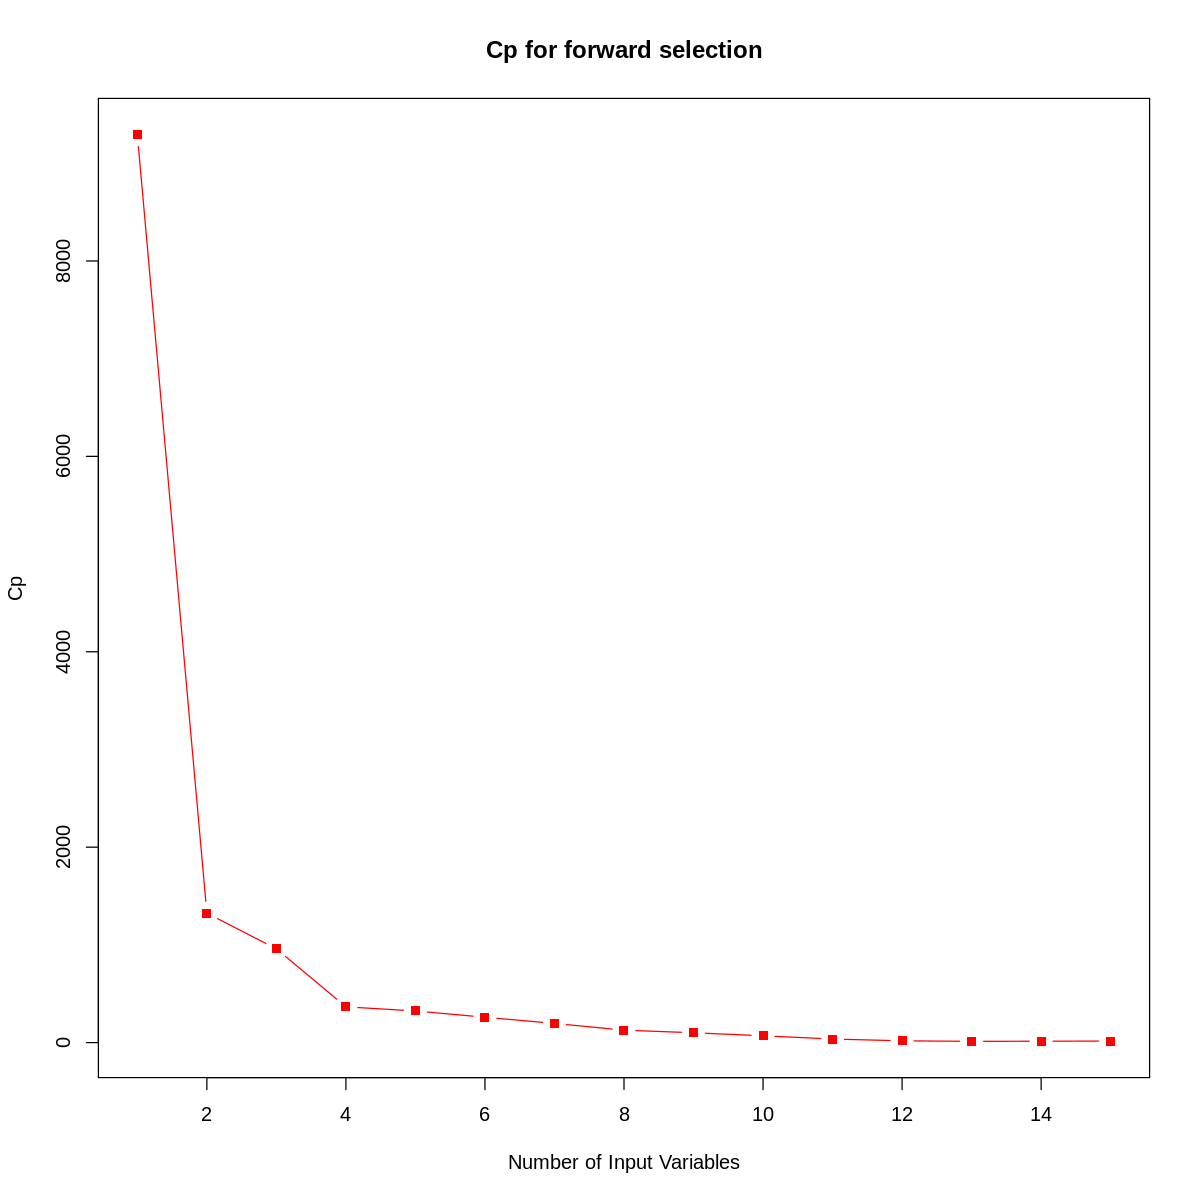

In [11]:
## Visualize the C_p value with model size:
plot(PM2.5_forward_summary$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "Cp", type = "b", pch = 15,
  col = "red"
)

From the second table & graph above, we observe that $C_p$ is smallest when the fitted model contains 14 variables, and then from the first table, we select all the variables selected by the algorithm when the model size equals to 14. This will lead us to the following model with the calculated RMSE from the validation set:  
**(Below are the 14 variables selected by the forward selection)**
- `year`: year of data in this row; (numeric, discrete)
- `month`: month of data in this row; (numeric, discrete)
- `hour`: hour of data in this row; (numeric, discrete)
- `DEWP`: Dew Point (â„ƒ); (numeric, continuous)
- `TEMP`: Temperature (â„ƒ); (numeric, continuous)
- `PRES`: Pressure (hPa); (numeric, continuous)
- `Is`: Cumulated hours of snow; (numeric, continuous)
- `Ir`: Cumulated hours of rain; (numeric, continuous)
- `Iws`: Cumulated wind speed (m/s); (numeric, continuous)
- `PM10`: PM10 concentration (ug/m^3); (numeric, continuous)
- `SO2`: SO2 concentration (ug/m^3); (numeric, continuous)
- `NO2`: NO2 concentration (ug/m^3); (numeric, continuous)
- `CO`: CO concentration (ug/m^3); (numeric, continuous)
- `O3`: O3 concentration (ug/m^3); (numeric, continuous)

In [12]:
## The fitted model with variables selected from the forward selection:
PM2.5_red_OLS_add<-lm(pm2.5 ~ year + month + hour + DEWP + 
                      TEMP + PRES + Is + Iws +Ir + PM10 + SO2 + O3 + NO2 + CO, data = PM2.5_train_final)
## Show the coefficients & P-value using tidy:
tidy(PM2.5_red_OLS_add)
## Calculate Validation set RMSE:
PM2.5_R_MSE_models <- rbind(
  PM2.5_R_MSE_models,
  tibble(
    Model = "OLS Reduced Regression",
    R_MSE = rmse(
         preds = predict(PM2.5_red_OLS_add, newdata = PM2.5_validation),
         actuals = PM2.5_validation$pm2.5
      )
    )
  )
PM2.5_R_MSE_models

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.070221e+04,1.246796e+03,8.5837678,1.025123e-17
year,-5.640841e+00,6.238886e-01,-9.0414238,1.770398e-19
month,-1.208056e+00,1.037019e-01,-11.6493136,3.342681e-31
hour,-3.573178e-01,4.908639e-02,-7.2793650,3.552958e-13
DEWP,1.164205e+00,4.740342e-02,24.5595189,3.828851e-130
TEMP,-7.522388e-01,7.145593e-02,-10.5273116,8.274064e-26
PRES,6.349997e-01,5.985156e-02,10.6095757,3.468701e-26
Is,1.599340e+00,5.919887e-01,2.7016392,6.909092e-03
Iws,4.471402e-02,7.621709e-03,5.8666659,4.558154e-09


Model,R_MSE
<chr>,<dbl>
OLS Full Regression,34.25041
OLS Reduced Regression,34.25038


From the calculated validation set RMSE, we can see that the model fitted with variables selected by forward selection performs better than the full model in terms of prediction accuracy. 

### 3.3 LASSO
Given that all the input & response variables in the dataset are numerical variables, we are able to fit a LASSO regression using the best lambda selected from a 10-fold cross validation. 

In [13]:
## Convert training & validation data to matrix
PM2.5_X_train <- PM2.5_train_final %>% select(- "pm2.5") %>% as.matrix()
PM2.5_Y_train <- PM2.5_train_final %>% select("pm2.5") %>% as.matrix()

PM2.5_X_validation <- PM2.5_validation %>% select(- "pm2.5") %>% as.matrix()
PM2.5_Y_validation <- PM2.5_validation %>% select(- "pm2.5") %>% as.matrix()

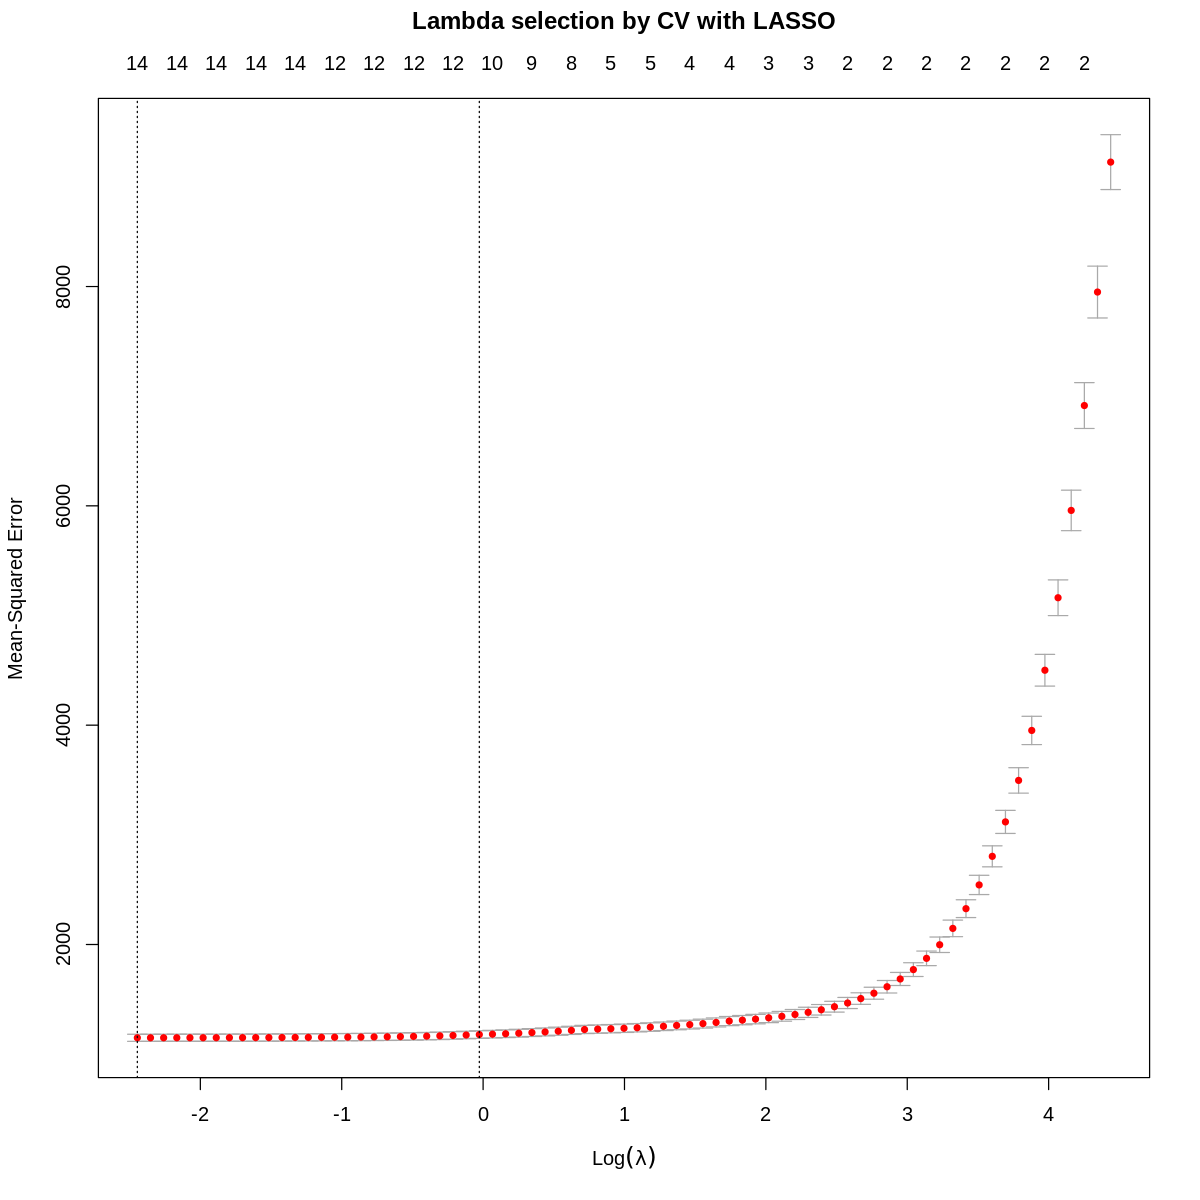

In [14]:
## Perform 10 fold cross-validation & visualize the result
PM2.5_cv_lambda_LASSO <- cv.glmnet(
  x = PM2.5_X_train, y = PM2.5_Y_train,
  alpha = 1, nfolds = 10
)
plot(PM2.5_cv_lambda_LASSO, main = "Lambda selection by CV with LASSO\n\n")

Although the best RMSE from the cross validation is from the `lambda.min`, we decide to calculate the RMSE for both the `lambda.1se` & `lambda.min` & use the better of the two results as the final RMSE for LASSO.

In [15]:
## LASSO with lambda.min
PM2.5_LASSO_min <- glmnet(
  x = PM2.5_X_train, y = PM2.5_Y_train,
  alpha = 1,
  lambda = PM2.5_cv_lambda_LASSO$lambda.min
)
## Caculate validation set RMSE for lambda.min
LASSO_RMSE <- tibble(
    Model = "LASSO Regression with lambda.min",
    R_MSE = rmse(
         preds = predict(PM2.5_LASSO_min, newx = PM2.5_X_validation),
         actuals = PM2.5_validation$pm2.5
      )
)
## LASSO with lambda.1se
PM2.5_LASSO_1se <- glmnet(
  x = PM2.5_X_train, y = PM2.5_Y_train,
  alpha = 1,
  lambda = PM2.5_cv_lambda_LASSO$lambda.1se
)
## Caculate validation set RMSE for lambda.1se
LASSO_RMSE <- rbind(
  LASSO_RMSE,
  tibble(
    Model = "LASSO Regression with lambda.1se",
    R_MSE = rmse(
         preds = predict(PM2.5_LASSO_1se, newx = PM2.5_X_validation),
         actuals = PM2.5_validation$pm2.5
      )
    )
  )
LASSO_RMSE

Model,R_MSE
<chr>,<dbl>
LASSO Regression with lambda.min,34.26077
LASSO Regression with lambda.1se,34.75900


We can see clearly here the LASSO with `lambda.min` performs better than with `lambda.1se`; thus, we will use LASSO with lambda.min as our model for LASSO; this leads to the following coefficients & validation RMSE:

In [16]:
#To get the coefficients:
tidy(PM2.5_LASSO_min)

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1,1.012009e+04,0.08666674,0.8749567
year,1,-5.331596e+00,0.08666674,0.8749567
month,1,-1.144863e+00,0.08666674,0.8749567
hour,1,-3.402910e-01,0.08666674,0.8749567
DEWP,1,1.124037e+00,0.08666674,0.8749567
TEMP,1,-7.059475e-01,0.08666674,0.8749567
PRES,1,5.950245e-01,0.08666674,0.8749567
Iws,1,4.075155e-02,0.08666674,0.8749567
Is,1,1.472602e+00,0.08666674,0.8749567


In [17]:
### Combine the RMSE results with the previous models
PM2.5_R_MSE_models <- rbind(
  PM2.5_R_MSE_models,
  tibble(
    Model = "LASSO Regression with minimum RMSE",
    R_MSE = rmse(
         preds = predict(PM2.5_LASSO_min, newx = PM2.5_X_validation),
         actuals = PM2.5_validation$pm2.5
      )
    )
  )
PM2.5_R_MSE_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,34.25041
OLS Reduced Regression,34.25038
LASSO Regression with minimum RMSE,34.26077


### 3.4 Ridge
Finally, we will use the Ridge regression with the best lambda tuned from the cross validation to fit the training data & obtain the RMSE from the validation set. Similar to how we did for the LASSO regression, we will use the better of the Ridge model with `lambda.1se` or with `lambda.min` as our final model. 

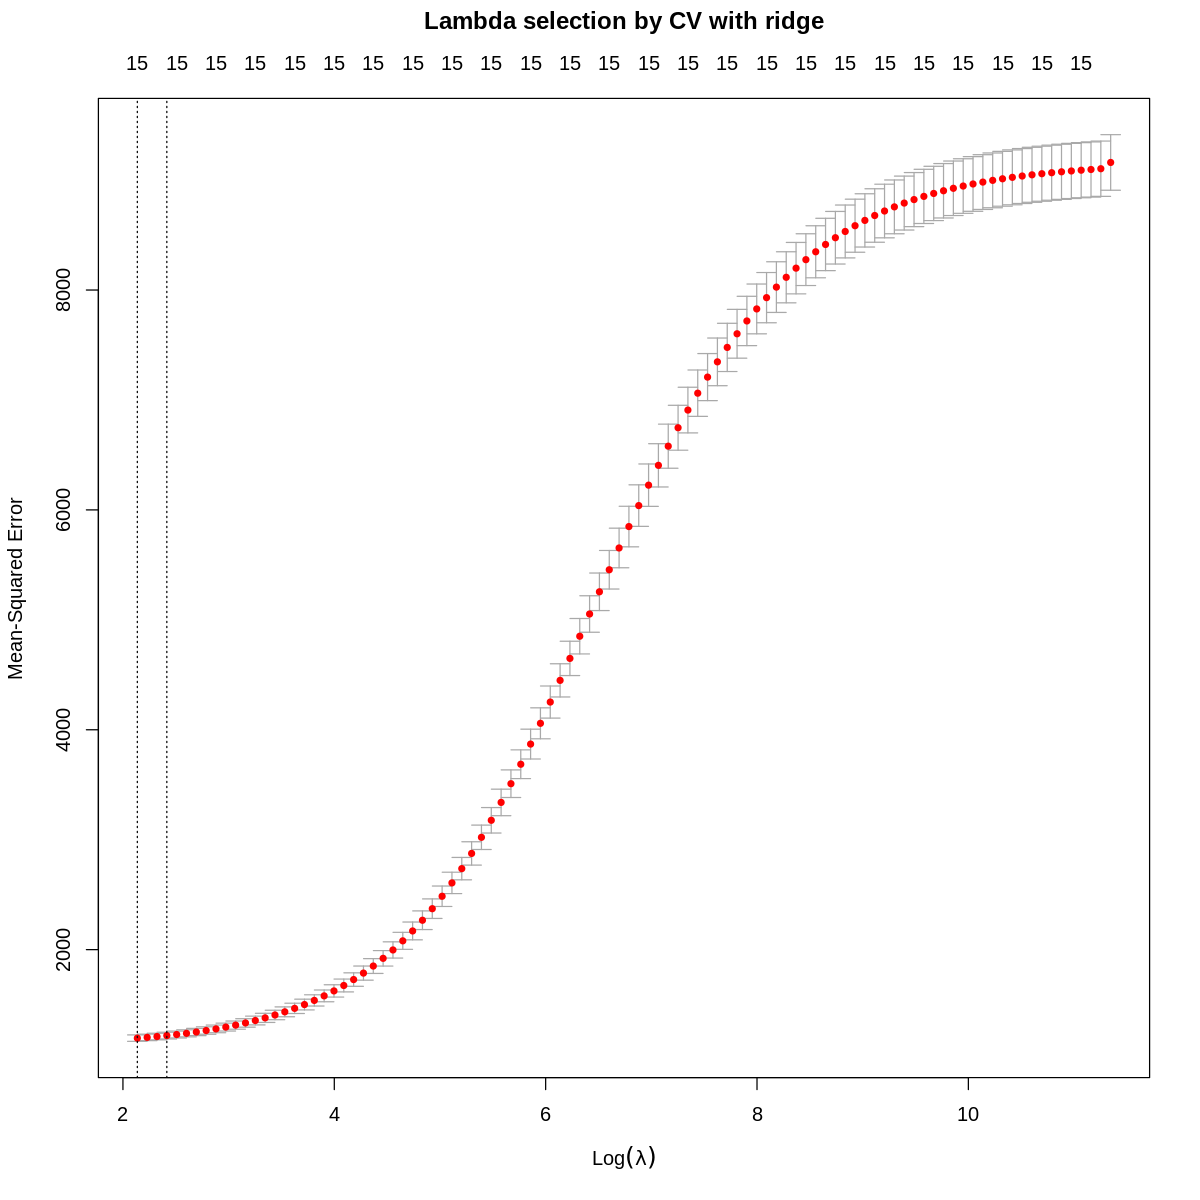

In [18]:
### Perform 10 Cross-validation to for lambda values & visualize the result:
PM2.5_cv_lambda_ridge <- cv.glmnet(
  x = PM2.5_X_train, y = PM2.5_Y_train,
  alpha = 0, nfolds = 10
)
plot(PM2.5_cv_lambda_ridge, main = "Lambda selection by CV with ridge\n\n")

In [19]:
## Ridge with lambda.min
PM2.5_Ridge_min <- glmnet(
  x = PM2.5_X_train, y = PM2.5_Y_train,
  alpha = 0,
  lambda = PM2.5_cv_lambda_ridge$lambda.min
)
## Caculate validation set RMSE for lambda.min
Ridge_RMSE <- tibble(
    Model = "Ridge Regression with lambda.min",
    R_MSE = rmse(
         preds = predict(PM2.5_Ridge_min, newx = PM2.5_X_validation),
         actuals = PM2.5_validation$pm2.5
      )
)
## LASSO with lambda.1se
PM2.5_Ridge_1se <- glmnet(
  x = PM2.5_X_train, y = PM2.5_Y_train,
  alpha = 0,
  lambda = PM2.5_cv_lambda_ridge$lambda.1se
)
## Caculate validation set RMSE for lambda.1se
Ridge_RMSE <- rbind(
  Ridge_RMSE,
  tibble(
    Model = "Ridge Regression with lambda.1se",
    R_MSE = rmse(
         preds = predict(PM2.5_Ridge_1se, newx = PM2.5_X_validation),
         actuals = PM2.5_validation$pm2.5
      )
    )
  )
Ridge_RMSE

Model,R_MSE
<chr>,<dbl>
Ridge Regression with lambda.min,35.05786
Ridge Regression with lambda.1se,35.42491


From the table above we can see that the better model (with smaller validation RMSE) would be the Ridge Regression with `lambda.min`; thus, we will use it as our final Ridge model:

In [20]:
## Get the coefficients
tidy(PM2.5_Ridge_min)

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1,8018.43036063,8.467427,0.8699959
year,1,-4.17337979,8.467427,0.8699959
month,1,-0.71007184,8.467427,0.8699959
day,1,0.02154490,8.467427,0.8699959
hour,1,-0.39904279,8.467427,0.8699959
DEWP,1,0.93352629,8.467427,0.8699959
TEMP,1,-0.50805912,8.467427,0.8699959
PRES,1,0.36383077,8.467427,0.8699959
Iws,1,0.03038179,8.467427,0.8699959


In [21]:
## Combine the validation RMSE with the results from Previous models
PM2.5_R_MSE_models <- rbind(
  PM2.5_R_MSE_models,
  tibble(
    Model = "Ridge Regression with minimum RMSE",
    R_MSE = rmse(
         preds =  predict(PM2.5_Ridge_min, newx = PM2.5_X_validation),
         actuals = PM2.5_validation$pm2.5
      )
    )
  )
PM2.5_R_MSE_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,34.25041
OLS Reduced Regression,34.25038
LASSO Regression with minimum RMSE,34.26077
Ridge Regression with minimum RMSE,35.05786


## 4. Final Evaluation & Results

From validation RMSE, we can see that all four models have very similar validation RMSE with the forward selection being the smallest among all (OLS Reduced Regression = 36.28753). Although here we would choose the forward selection method as our final model & evaluate it against our test set, we would argue that there are benefits & reasons for using other models as well, especially with LASSO & Ridge. For instance, Ridge in particular produces smaller coefficients which would lead to stabler predictions & less overfitting. As for LASSO, it chooses variables smoothly & removes highly correlated variables from the model which both effectively reduces the model size & decreases multicollinerity problem present in the data. 

The Table below shows the coefficients of the fitted LASSO, OLS, & Ridge model. We can see that coefficient for `day` in the LASSO is 0 (variable selection), and Ridge gives smaller coefficients than the OLS.

In [22]:
### Create a table with coefficients of OLS, Lasso, & Ridge Model
PM2.5_ridge_min_add.coef <- PM2.5_Ridge_min$beta
PM2.5_reg_coef2 <- round(cbind(
  Full_OLS = coef(PM2.5_full_OLS),
  Ridge_min = c(
    PM2.5_Ridge_min$a0,
    as.vector(PM2.5_ridge_min_add.coef)
  ) ,  
    LASSO_min = c(
    PM2.5_LASSO_min$a0,
    as.vector(PM2.5_LASSO_min$beta)
  )
), 4) %>% as.data.frame()
PM2.5_reg_coef2

,Full_OLS,Ridge_min,LASSO_min
,<dbl>,<dbl>,<dbl>
(Intercept),10706.4752,8018.4304,10120.0864
year,-5.6430,-4.1734,-5.3316
month,-1.2080,-0.7101,-1.1449
day,-0.0052,0.0215,0.0000
hour,-0.3575,-0.3990,-0.3403
DEWP,1.1640,0.9335,1.1240
TEMP,-0.7515,-0.5081,-0.7059
PRES,0.6351,0.3638,0.5950
Iws,0.0448,0.0304,0.0408


### 4.1 Evaluation of the Selected Model Against the Test Set:
Finally, we use the `OLS Reduced Regression` from the forward selection model to calculate the test RMSE. The resulting test RMSE as the table below shown is $33.2379$ which is smaller than the best validation RMSE.

In [23]:
### The Create the table containing the test RMSE with the OLS Reduced Regression from variable selection
test_RMSE <-   tibble(
    Model = "OLS Reduced Regression",
    Test_R_MSE = rmse(
         preds = predict(PM2.5_red_OLS_add, newdata = PM2.5_test),
         actuals = PM2.5_test$pm2.5
      )
    )
test_RMSE

Model,Test_R_MSE
<chr>,<dbl>
OLS Reduced Regression,33.2379


### 4.3 Discussion of Results
Since the test RMSE is small, we argue that our final model is a good predictor of PM2.5 level in Beijing. However, given that our data is pretty dated (from 2013 - 2014), our concern is that there might be serious extrapolation issues if we want to use this model to predict the current pm2.5 level in Beijing, China. (Perhaps to predict the current pm2.5 level, Ridge model might be a little bit more accurate because it has smaller coefficients which would yield stabler results?) Nevertheless, we consider our model sucessful in terms of predicting a reasonable pm2.5 level in Beijing, China with weather condition, air quality, and time value provided & believe that our study in this area can shed light to the related areas such as weather forecasting since the variables we fitted our data with are common in weather monitoring & can be used easily to predict the future pm2.5 level with our fitted model. 

### 5. Reference

Brook, R. D., et al. (2010). Particulate matter air pollution and cardiovascular disease: an update to the scientific statement from the American Heart Association. Circulation, 121(21), 2331-2378.

UCI Machine Learning Repository. (n.d.). Beijing multi-site air-quality data [Data set]. Retrieved from https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

UCI Machine Learning Repository. (n.d.). PRSA2017 data 20130301-20170228 [Data set]. Retrieved from https://archive.ics.uci.edu/ml/machine-learning-databases/00501/

World Health Organization. (2018). 7 million premature deaths annually linked to air pollution. Retrieved from https://www.who.int/news-room/detail/02-10-2018-7-million-premature-deaths-annually-linked-to-air-pollution
